In [1]:
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.stats.kde import gaussian_kde
from numpy import linspace
from copy import deepcopy
from src.fewshot_ner_viz_component.fewshot_ner_binary_classifier import FewshotNerBinaryClassifier, CompositeEmbedder
from src.fewshot_ner_viz_component.data_processing import *

/home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
2018-09-03 19:00:57.401 DEBU

In [2]:
dataset_orig = read_data()

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [3]:
ne_type = 'PERSON'
dataset = filter_dataset_by_ne_types(dataset_orig, ne_type)

Num of train sentences: 12195
Num of valid sentences: 1553
Num of test sentences: 1573


In [4]:
# embedders = {'ELMo':CompositeEmbedder(use_elmo=True, elmo_scale=1, cap_scale=1, use_cap_feat=False, use_glove=False),
#             'GloVe':CompositeEmbedder(use_elmo=False, elmo_scale=1, cap_scale=1, use_cap_feat=False, use_glove=True)}

In [5]:
embedders = {'FastText':CompositeEmbedder(use_elmo=False, elmo_scale=1, cap_scale=1, use_cap_feat=False, use_glove=False, use_fastText=True)}

2018-09-03 19:01:18.908 INFO in 'deeppavlov.models.embedders.fasttext_embedder'['fasttext_embedder'] at line 69: [loading embeddings from `/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/wiki.en.bin`]


In [6]:
np.random.seed(11)
data_sample_support = get_data_sample(dataset['test'], 10)
np.random.seed(12)
data_sample_query = get_data_sample(dataset['test'], 100)
print(len(data_sample_support[0]))
print(len(data_sample_query[0]))

10
100


FastText embeddings


2018-09-03 19:06:04.583 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1343: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/kostrovskiy/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-09-03 19:06:04.741 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1343: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/kostrovskiy/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


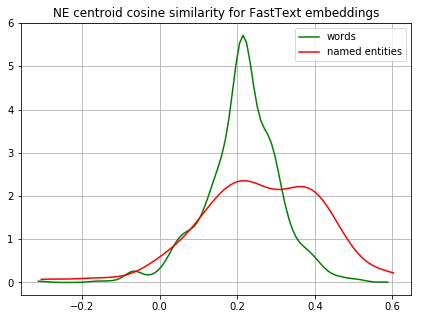

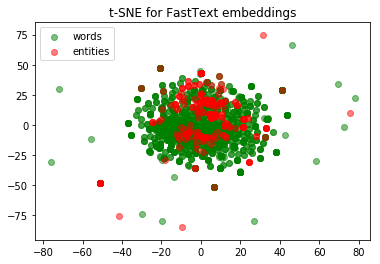

In [7]:
for i, (name, embedder) in enumerate(embedders.items()):
    print('{} embeddings'.format(name))
    X_s, y_s = get_matrices(*data_sample_support, embedder)
    X_q, y_q = get_matrices(*data_sample_query, embedder)
    X_s_ne = X_s[y_s == 1, :]
    X_s_words = X_s[y_s == 0, :]
    ne_centroid_s = np.mean(X_s_ne, axis=0)
    words_centroid_s = np.mean(X_s_words, axis=0)
    X_q_ne = X_q[y_q == 1, :]
    X_q_words = X_q[y_q == 0, :]
    sims = calc_sim_by_type(X_q, ne_centroid_s, sim_type='cosine')
    plotPDE(sims, y_q, 'NE centroid cosine similarity for {} embeddings'.format(name))
    plot_tSNE(X_q, y_q, title='t-SNE for {} embeddings'.format(name))